Lecture 4 - Exercises

## Q2: Interpolation error

There are a large number of different interpolation schemes available through scipy.  Let's test them out.

Create a python function, $f(x)$, that is your true function (make it complicated!).  Now create $N$ samples of it (either regularly spaced or irregularly spaced).

Try some of the different interpolation routines.  `interpolate.interp1d` takes a `kind` argument that lets you choose the order of the interpolation.  Measure the error in the method, by comparing the interpolated result with the actual function value.  

Then do the same cubic splines (look at `CubicSpline`)

Plot the resulting interpolant.

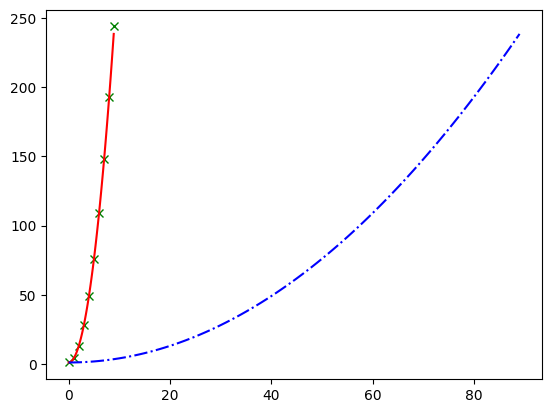

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

x = np.arange(0, 10)
def y(x) : 
    return 3*(x**2)+1
f_interp = interpolate.interp1d(x, y(x), kind='cubic')
f_spline = interpolate.CubicSpline(x,y(x))



xnew = np.arange(0, 9, 0.1)
ynew_interp = f_interp(xnew)
ynew_spline = f_spline(xnew)  
plt.plot(x, y(x), 'gx', xnew, ynew_interp, 'r-',ynew_spline, 'b-.')





## Q8: FFT of the chaotic pendulum

In Q6 we looked at ODEs and the chaotic pendulum, and were interested in writing a method to integrate the pendulum in time.

Here we want to examine its behavior in frequency space.  The code below will integrate the chaotic pendulum, while requesting that the solution be stored at points spaced with a fixed dt, which makes it suitable for taking the FFT.

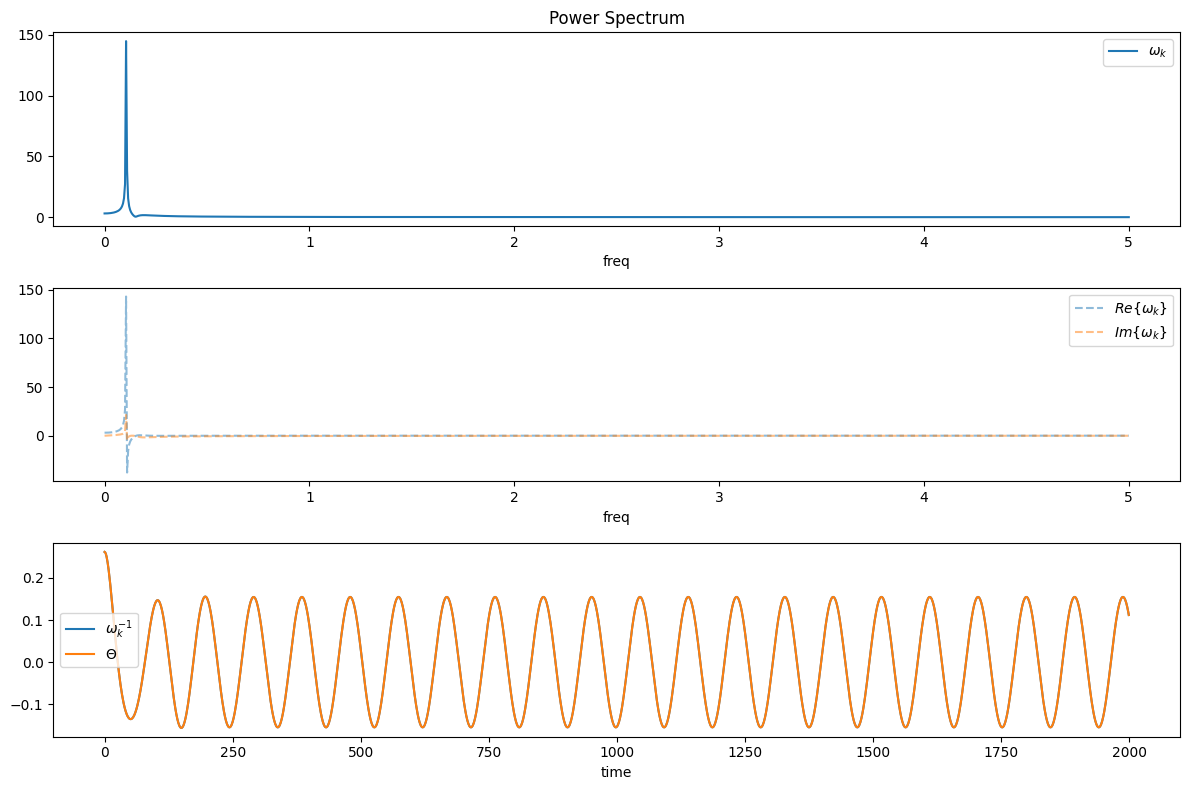

In [7]:
from functools import partial
from scipy.integrate import solve_ivp

def rhs(t, Y, q, omega_d, b):
    """ damped driven pendulum system derivatives.  Here, Y = (theta, omega) are
        the solution variables. """
    f = np.zeros_like(Y)
        
    f[0] = Y[1]
    f[1] = -q*Y[1] - np.sin(Y[0]) + b*np.cos(omega_d*t)

    return f

def restrict_theta(theta):
    """ convert theta to be restricted to lie between -pi and pi"""
    tnew = theta + np.pi
    tnew += -2.0*np.pi*np.floor(tnew/(2.0*np.pi))
    tnew -= np.pi
    return tnew

def int_pendulum(theta0, q, omega_d, b, tend, dt):
    """ integrate the pendulum and return solution with dt"""

    # points in time where we'll request the solution
    tpoints = np.arange(0.0, tend, dt)
    
    r = solve_ivp(partial(rhs, q=q, omega_d=omega_d, b=b),
                  [0.0, tend], [theta0, 0.0],
                  method='RK45', t_eval=tpoints)

    return r.t, r.y

def power_spectrum(t, theta):
    """Return the power spectrum of theta."""
    theta = restrict_theta(theta)
    npts = len(theta)

    # FFT
    omega_k = np.fft.rfft(theta)
    omega_k_mag = np.abs(omega_k)
    omega_k_r = omega_k.real
    omega_k_i = omega_k.imag

    # Frequencies
    kfreq = np.fft.rfftfreq(npts, d=t[1] - t[0])

    # Inverse FFT for verification
    omega_k_inv = np.fft.irfft(omega_k)

    return kfreq, omega_k_mag, omega_k_r, omega_k_i, omega_k_inv

# Parameters
theta0 = np.radians(15)  # Initial angle
q = 0.5  # Damping
omega_d = 0.6666  # Driving frequency
b = 0.1  # Driving amplitude
tend = 200.0  # Simulation time
dt = 0.1  # Time step

# Solve the pendulum
t, y = int_pendulum(theta0, q, omega_d, b, tend, dt)

# Compute the power spectrum
theta = y[0]  # theta is the first variable
kfreq, omega_k_mag, omega_k_r, omega_k_i, omega_k_inv = power_spectrum(t, theta)

fig,ax = plt.subplots(3,1,figsize=(12,8))
ax[0].set_title("Power Spectrum")
ax[0].plot(kfreq,omega_k_mag, label=r"$\omega_k$")
ax[1].plot(kfreq,omega_k_r,'--',alpha=0.5, label=r"$Re\{\omega_k\}$")
ax[1].plot(kfreq,omega_k_i,'--',alpha=0.5, label=r"$Im\{\omega_k\}$")
ax[2].plot(omega_k_inv, label=r"$\omega_k^{-1}$")
ax[2].plot(theta, label=r"$\Theta$")
ax[0].legend(loc=0)
ax[1].legend(loc=0)
ax[2].legend(loc=0)

ax[0].set_xlabel('freq')
ax[1].set_xlabel('freq')
ax[2].set_xlabel('time')

plt.tight_layout()


